6000 6000


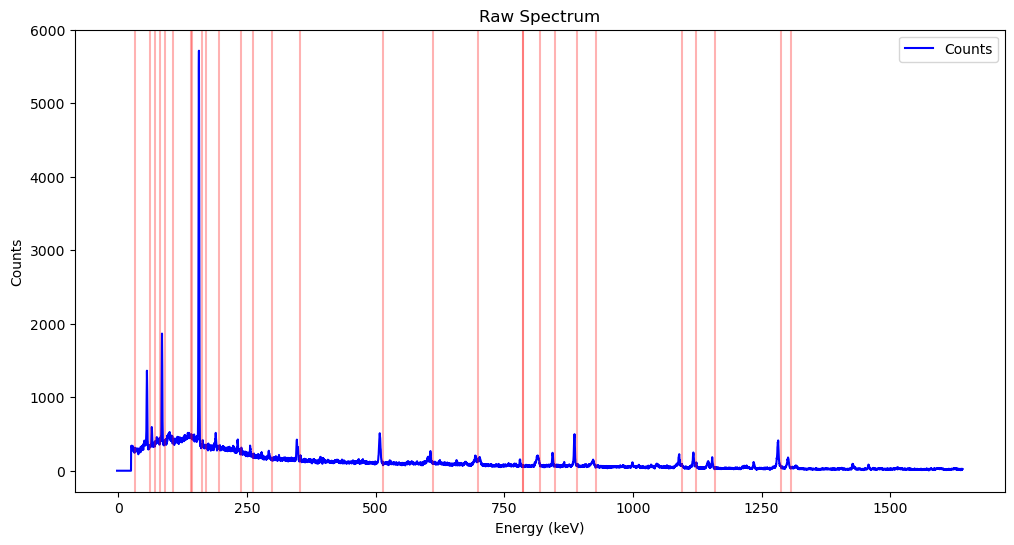

In [1]:
import requests
import random
import numpy as np
import pandas as pd
import scipy.optimize as scipyo
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
from matplotlib import cm
from itertools import combinations
from itertools import permutations
from  matplotlib.colors import LogNorm
import time
import os
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
import scipy.signal as scipy



# This cell imports libraries, displays a piece of real spectrum data, and defines plotting functions.


github_url = "https://raw.githubusercontent.com/JPittard10/Isomer-Project/refs/heads/main/Trimmed%20and%20Bunched%20Spectrums/A1_Cl37_c10_HPGe_301sec_trimmed.txt"

response = requests.get(github_url)

data1 = response.text
data1_array = np.array(list(map(int, data1.split())))
bin_array = list(range(1,(len(data1_array)+1)))

Energy_bin = 0.64844 + 0.27383 * np.array((np.array(bin_array)) - 12.5)

prominence = 1e2


# Name: Sir_Peaks_plotalot
# Purpose : plots a line on the spectrum plot where the peak was identified
# Creator : James Pittard - 29 / FEB / 2025
# Function : sir_peaks_printsalot( the array for where peaks want to be identified, name of the plot where the peak lines will be displayed i.e plot1 )



def sir_peaks_plotalot(plot_array, plot_name):
    plot_peaks, _ = scipy.find_peaks(plot_array, prominence = 1e2)
    plot_peaks_energy = (0.64844 + 0.27383 * np.array((plot_peaks) - 12.5))+6
    for peak in plot_peaks_energy:
        plot_name.axvline(x = peak, color = 'red', alpha = 0.3)
    return(plot_peaks)


# Name: Sir_Peaks_displayalot
# Purpose : displays the energy of the peaks and their respective counts from greatest to largest count, and prints all of the peaks
#           in order from the left to right side of the array
# Creator : James Pittard - 29 / FEB / 2025
# Function : sir_peaks_displayalot( the array for where peaks want to be identified, the name of the array must start with a " ' " and end with a " ' " )

def sir_peaks_displayalot(plot_array, plot_name):
    plot_peaks, _ = scipy.find_peaks(plot_array, prominence = 1e2)
    plot_peaks_energy = (0.64844 + 0.27383 * np.array((plot_peaks) - 12.5))+6
    peak_counts = plot_array[plot_peaks]
    sorted_peaks = np.argsort(peak_counts)[::-1]
    print(f"Sorted Peaks For Plot '{plot_name}'")
    print("Peak Energy (keV) | Counts")
    print("-----------------------------")
    for i in sorted_peaks:
        peak_index = plot_peaks[i]
        formatted_peak_energy = f"{plot_peaks_energy[i]:<17.3f}"
        formatted_counts = f"{plot_array[peak_index]:<10.0f}"
        print(f"{formatted_peak_energy} | {formatted_counts}")
    print("-----------------------------")
    print(f"Peaks For Plot '{plot_name}'")
    print("Peak Energy (keV)")
    for energy in plot_peaks_energy:
        print(f"{energy:<0.3f}")
    print("-----------------------------\n\n")

# Name: Plot_func
# Purpose: displays spectrum data plainly without labeling peaks
# Creator: James Pittard
# Function: plot_func(x-axis of data, y-axis of data, name of x-axis, name of y-axis, name of graph, x-axis units, y-axis units, color)

def plot_func(x_axis_data, y_axis_data, x_axis_name, y_axis_name, title_name, x_axis_unit, y_axis_unit, color_type):
    spec_plot = pd.DataFrame({x_axis_name: x_axis_data, y_axis_name: y_axis_data})
    plot = spec_plot.plot(x = x_axis_name, y = y_axis_name, title = title_name,
                          xlabel = x_axis_unit, ylabel = y_axis_unit, color = color_type, figsize = (12,6))

    return(plot)
    
# Name: Plot_peaks_func
# Purpose: displays spectrum data and identifies and labels peaks on the data
# Creator: Mason Levere
# Function: plot_peaks_func(x-axis of data, y-axis of data, name of x-axis, name of y-axis, name of graph, x-axis units, y-axis units, color (default of blue))
    
def plot_peaks_func(x_axis_data, y_axis_data, x_axis_name, y_axis_name, title_name,
                    x_axis_unit, y_axis_unit, color_type='blue', prominence=prominence):
    # detect peaks (prominence at 1e2, should be changed)
    plot_peaks, _ = scipy.find_peaks(y_axis_data, prominence=prominence)
    peak_energies = x_axis_data[plot_peaks]
    peak_counts = y_axis_data[plot_peaks]
    sorted_peaks = np.argsort(peak_counts)[::-1]

    # create df and plot
    spec_plot = pd.DataFrame({x_axis_name: x_axis_data, y_axis_name: y_axis_data})
    ax = spec_plot.plot(x=x_axis_name, y=y_axis_name, title=title_name,
                        xlabel=x_axis_unit, ylabel=y_axis_unit, color=color_type, figsize=(12, 6))


    # label peaks
    peak_list = []
    for i in sorted_peaks:
        x = peak_energies[i]
        peak_list.append(x)
        y = peak_counts[i]
        ax.plot(x, y, 'ro')  # red circle marker
        ax.text(x, y, f"{x:.1f} keV\n{int(y)}", fontsize=8, ha='center', va='bottom', rotation=0)

    peak_list = np.sort(np.round(peak_list, 1))
        

    plt.tight_layout()
    return peak_list

# Name: get_nice_colors
# Purpose: generates "n" random colors 
# Creator: Mason Levere
# Function: get_nice_colors(number of colors, color map pool)

def get_nice_colors(n, cmap_name='tab10'):
    cmap = plt.cm.get_cmap(cmap_name)
    return [cmap(i % cmap.N) for i in range(n)]

# Name: get_random_named_color
# Purpose: chooes a random color from CSS4 pool
# Creator: Mason Levere
# Function: get_random_named_color()

def get_random_named_color():
    return random.choice(list(mcolors.CSS4_COLORS.keys()))


# Name: Plot_func_ladders
# Purpose: plots ladder arrays in different colors for readability
# Creator: Mason Levere
# Function plot_func_ladders(x-range, list of ladder arrays, x-axis name, y-axis name, plot name, x-axis units, y-axis units, color pool)

def plot_func_ladders(x_axis_data, y_axis_data, x_axis_name, y_axis_name, title_name, x_axis_unit, y_axis_unit, color_type):

    # create df with one column for each y dataset
    data = {x_axis_name: x_axis_data}
    for i, y in enumerate(y_axis_data):
        data[f"{y_axis_name}_{i+1}"] = y
    spec_plot = pd.DataFrame(data)

    # generate color list
    colors = get_nice_colors(len(y_axis_data))

    # plot all y-columns 
    y_columns = [f"{y_axis_name}_{i+1}" for i in range(len(y_axis_data))]
    spec_plot.plot(
        x=x_axis_name,
        y=y_columns,
        title=title_name,
        xlabel=f"{x_axis_name} ({x_axis_unit})",
        ylabel=f"{y_axis_name} ({y_axis_unit})",
        color=colors,
        figsize=(12, 6)
    )

    plt.show()
    return()

###

def plot_level_bands(bands, spacing=3, line_length=0.5, label_offset=0.6, energy_offset=0.3):
    plt.figure(figsize=(spacing * len(bands), 10))  # increased vertical size
    ax = plt.gca()

    for i, band in enumerate(bands):
        x_offset = i * spacing
        nodes = band["nodes"]
        edges = band["edges"]

        for label, energy in nodes.items():
            ax.hlines(y=energy,
                      xmin=x_offset - line_length / 2,
                      xmax=x_offset + line_length / 2,
                      color='black', linewidth=2)

            # labels
            ax.text(x_offset + label_offset, energy, label,
                    verticalalignment='center', horizontalalignment='left',
                    fontsize=11, fontweight='bold')

        # transitions
        for u, v in edges:
            y_start = nodes[u]
            y_end = nodes[v]
            mid_y = (y_start + y_end) / 2
            delta_E = y_start - y_end

            ax.annotate("",
                        xy=(x_offset, y_end),
                        xytext=(x_offset, y_start),
                        arrowprops=dict(arrowstyle="->", lw=1.5))

            ax.text(x_offset - energy_offset, mid_y, f"{delta_E:.1f} keV",
                    fontsize=9, va='center', ha='right')

        # band label
        top_energy = max(nodes.values())
        ax.text(x_offset, top_energy + 100, band["name"],
                ha='center', va='bottom', fontsize=13, fontweight='bold')

    # formatting
    max_energy = max(max(b["nodes"].values()) for b in bands)
    ax.set_ylim(-50, max_energy + 200)  # more space on top
    ax.set_xlim(-1, len(bands) * spacing)
    ax.set_title("Level Scheme", fontsize=16, pad=40)  # padded title
    ax.axis('off')
    plt.show()  # removed tight_layout to avoid clipping title





raw_spec_plot = plot_func(Energy_bin, data1_array, 'Energy', 'Counts', 'Raw Spectrum', 'Energy (keV)', 'Counts', 'blue')
peaks_raw_spec = sir_peaks_plotalot(data1_array, raw_spec_plot)


#should plot based on FHWM
#------------ rel_height at 0.3 for background -------------#

#width, width_heights, left_ips, right_ips = scipy.peak_widths(data1_array, peaks_raw_spec, rel_height=0.3)

print(len(bin_array), len(Energy_bin))


In [19]:
# 1D plot building functions


# Name: Gaussian_peak
# Purpose: creates a gaussian
# Creator: Mason Levere
# Function: gaussian_peak(x bins, amplitude, center, standard deviation)

def gaussian_peak(x, A, mu, sigma):

    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    

# Name: Peak_inserter
# Purpose: generate y-values of gaussian peaks based off of real spectroscopy data (1D)
# Creator: Mason Levere
# Function: peak_inserter(x-axis, list of index values of peaks in x-axis, list of peak widths, y-values of spectroscopy data)

def peak_inserter(Energy_bin, peaks, width, data1_array):
    num_peaks = len(peaks)
    just_peaks = np.zeros(len(Energy_bin))
    print(peaks)
    for i in range(len(peaks)):
        peak_index = peaks[i]
        peak_height = data1_array[peak_index]
        sd = width[i]/2
        left = np.int64(np.ceil(peak_index - ((2*width[i])/0.27383)))
        right = np.int64(np.ceil(peak_index + ((2*width[i])/0.27383)))
        x_range = np.array(range(left, right))
        gaussian_part = gaussian_peak(x_range, peak_height, x_range[int((right-left)/2)], sd)
        int_indices = np.clip(np.round(x_range).astype(int), 0, len(just_peaks) - 1)
        np.add.at(just_peaks, int_indices, gaussian_part)
        
    return just_peaks

# Name: Peak_inserter_ladder
# Purpose: generates the arrays for ladders seperately and also gives the boundaries and integrals of the peaks (1D)
# Creator: Mason Levere
# Function: peak_inserter_ladder(x-range, list of lists of peaks, list of lists of peak heights, list of lists of widths)

def peak_inserter_ladder(Energy_bin, peaks, peak_height, width):
    peak_arrays = []
    boundaries = []
    integrals = []
    for j in range(len(peaks)): 
        num_peaks = len(peaks[j])
        just_peaks = np.zeros(len(Energy_bin))
        boundary = []
        integral = []
        for i in range(len(peaks[j])):
            peak_index = peaks[j][i]
            peak_height_num = peak_height[j][i]
            sd = width[j][i]/2
            left = np.int64(np.ceil(peak_index - ((width[j][i])/0.27383)))
            right = np.int64(np.ceil(peak_index + ((width[j][i])/0.27383)))
            x_range = np.array(range(left, right))

            gaussian_part = gaussian_peak(x_range, peak_height_num, x_range[int((right-left)/2)], sd)
            int_indices = np.round(x_range).astype(int)
            int_indices = np.clip(int_indices, 0, len(just_peaks) - 1)
            np.add.at(just_peaks, int_indices, gaussian_part)
            
            total_counts = np.int64(np.sum(gaussian_part))
            boundary.append([left, right])
            integral.append(total_counts)
        peak_arrays.append(just_peaks)
        boundaries.append(boundary)
        integrals.append(integral)
       
    return(peak_arrays, boundaries, integrals)


# Name: add_ladders
# Purpose: takes multiple ladders in 1D and shows their sum
# Creator: Mason Levere
# Function: add_ladders(list of ladder arrays)

def add_ladders(ladders):
    matrix = np.sum(ladders, axis = 0)
    return(matrix)

# 1D and 2D ladder parameter functions

# Name: Generate_ladder
# Purpose: Creates the positions, heights, and widths for a ladder within a given range of x values. 
# If the ladder is out of bounds, it resets and tries again. By default, it will generate a ldadder based on random parameters, 
# but parameters can be passed to fix certain values.
# It also generates random values for ground decay.
# (needs some work)
# Creator: Mason Levere
# Function: generate_ladder(x boundaries, fixed width for each peak, accuracy of detector, number of rungs in ladder, 
# inital x. initial y, distance between rungs)

def generate_ladder(Energy_bin, width, ground, accuracy, rungs=None, x0=None, y0=None, d0=None, size=4096):
    scale = size/4096
    if rungs == None:
        rungs = np.random.randint(3, 5)
    if x0 == None:
        x0 = np.random.randint(30, (size-30))
    if y0 == None:
        y0 = np.random.randint(150, 1000)
    if d0 == None:
        d0 = np.int64(np.random.randint(30, 400)*(scale))
    
    # widths made bigger for now
    positions = [x0]
    heights = [y0]
    #widths = [np.int64(np.random.normal(np.mean(width), accuracy))*5]
    widths = [np.int64(20*scale)]

    for j in range(1, rungs):
        rung_index = positions[j - 1] + np.int64(d0 * np.random.normal(1, accuracy))
        if (rung_index >= size) or (rung_index <= 0) : # -30 to prevent plotting on the edge
            return None  # failed ladder
        rung_height = np.int64(heights[j - 1] * np.random.uniform(0.5, 0.9))
        # width changed here too
        #rung_width = np.int64(np.random.normal(np.mean(width), accuracy)) * 5
        rung_width = np.int64(20*scale)

        positions.append(rung_index)
        heights.append(rung_height)
        widths.append(rung_width)

    # ground transition (WIP)
    if ground:
        ground_transition_energy = np.random.randint(0, size)
        ground_tranisition_intensity = np.int64(2 * max(heights))
        #ground_tranisition_width = np.int64(np.random.normal(np.mean(width), accuracy))*5
        ground_tranisition_width = np.int64(20*scale)
        positions.insert(0, ground_transition_energy)
        heights.insert(0, ground_tranisition_intensity)
        widths.insert(0, ground_tranisition_width)

    return positions, heights, widths



#### WEIRD but works

def snake_ladder(positions, heights, widths, rungs, size, threshold=0.3):
        scale = size/4096
        positions_lst = []
        heights_lst = []
        widths_lst = []
        i = 1
        while True: # one band feature, keeps running until failure
            chance = random.uniform(0, 1) 
            if chance < threshold:
                #index = random.randint(0, len(positions)-1) random index
                index = len(positions)-1 #last index (last was ground, now first is)
                x0 = positions[index] 
                y0 = heights[index]
                d0 = (np.random.randint(30, 400)*(scale)) * ((-1)**i) # term is negative for odd i, positive for even i
                # needs to be put back as variables
                result = generate_ladder(Energy_bin, np.int64(20*scale), 0, 0.02, rungs, x0, y0, d0, size)
                if result is not None:
                    positions, heights, widths = result

                    positions_lst.extend(positions[1:])
                    heights_lst.extend(heights[1:])
                    widths_lst.extend(widths[1:])
                    i += 1
                    if i == 3:
                    # can only snake back twice
                        break
                else:
                    #print(f"Failed after {i} attempts")
                    break
        return positions_lst, heights_lst, widths_lst


# Name: Peak_ladder
# Purpose: generates multiple ladders and outputs their parameters
# Creator: Mason Levere
# Function: peak_ladder(number of ladders, accuracy of detector, chance of a 'split' (idea of split needs work), width (default to 5 for convenience)

def peak_ladder(num_ladders, accuracy, max_rungs, size, threshold=0.8, width=20):
    scale = size/4096
    width = np.int64(20*scale)
    peak_index = []
    peak_height = []
    peak_width = []

    i = 0
    while i < num_ladders:
        result = generate_ladder(Energy_bin, width, 1, accuracy, max_rungs, size=size)

        if result is not None:
            positions, heights, widths = result

            peak_index_temp = positions.copy()
            peak_height_temp = heights.copy()
            peak_width_temp = widths.copy()

            # Try to extend the band with a snake branch
            if threshold > random.random():
                result2 = snake_ladder(positions, heights, widths, max_rungs, threshold=threshold, size=size)
                if result2 is not None:
                    positions_lst, heights_lst, widths_lst = result2
                    peak_index_temp.extend(positions_lst)
                    peak_height_temp.extend(heights_lst)
                    peak_width_temp.extend(widths_lst)

            # Only add results if the main ladder was successfully created
            peak_index.append(peak_index_temp)
            peak_height.append(peak_height_temp)
            peak_width.append(peak_width_temp)

            i += 1  # Only count if the core ladder is valid
        else:
            #print("generate_ladder failed, retrying...")
            x = 0

    return peak_index, peak_height, peak_width


# Name: made_dict
# Purpose: make a dictionary given two lists of same dimension
# Creator: Mason Levere
# Function: make_dict(list of keys, corresponding list of values)

def make_dict(keys, values):
    return dict(zip(keys, values))

# Name: TwoDParameters
# Purpose: generates coordinates, amplitudes, and widths of peaks for a 2D matrix
# Creator: Mason Levere
# Function: TwoDParameters(list of lists of peak_indexs, list of lists for coincidences (this is taken from 
# the visual of a level scheme, counts are proportional to amplitudes due to plotting within a set sd), list of lists of peak widths)


def TwoDParamaters(peak_index, peak_height, peak_width):
    peak_index_parameter = []
    peak_height_parameter = []
    peak_width_parameter = []
    for i in range(len(peak_index)):
        lst_index = peak_index[i]
        lst_height = peak_height[i]
        lst_width = peak_width[i]
        lst_height_width = list(zip(lst_height, lst_width))
        index_height_dic = make_dict(lst_index, lst_height_width)
        coordinates = list(permutations(lst_index, 2))
        heights = [min([index_height_dic[item][0] for item in tup]) for tup in coordinates]
        widths = [tuple(index_height_dic[x][1] for x in tup) for tup in coordinates]
        peak_index_parameter.append(coordinates)
        peak_height_parameter.append(heights)
        peak_width_parameter.append(widths)
         
    peak_index_parameter = [tup for sublist in peak_index_parameter for tup in sublist]
    peak_height_parameter = [item for sublist in peak_height_parameter for item in sublist]
    peak_width_parameter = [tup for sublist in peak_width_parameter for tup in sublist]

    return(peak_index_parameter, peak_height_parameter, peak_width_parameter)
    
# 2D Functions

# Name: GateVertical
# Purpose: takes a vertical gate of a 2D matrix
# Creator: Mason Levere
# Function: GateVertical(2D matrix, center of gate, width from center of gate)

def GateVertical(matrix, energy, gate_width = 60):
    channel = EnergytoChannel(energy)
    gate_width = EnergytoChannel(gate_width)
    arrays = (matrix[:][(channel-gate_width):(channel+gate_width)])
    array = np.sum(arrays, axis=0)
    return(array)

# Name: GateHorizontal
# Purpose: takes a horizontal gate of a 2D matrix
# Creator: Mason Levere
# Function: GateHorizontal(2D matrix, center of gate, width from center of gate)

def GateHorizontal(matrix, energy, gate_width = 60):
    channel = EnergytoChannel(energy)
    gate_width = EnergytoChannel(gate_width)    
    arrays = (matrix[(channel-gate_width):(channel+gate_width)][:])
    array = np.sum(arrays, axis=0)
    return(array)
    
# Name: EnergytoChannel
# Purpose: takes an energy and converts to a channel index
# Creator: Mason Levere
# Function: EnergytoChannel(energy)

def EnergytoChannel(energy):
    channel_number = np.int64((energy-1.785)/0.99943)
    
    return(channel_number)

# Name: Gate
# Purpose: Gate on a 2D matrix given a center energy and width
# Creator: Mason Levere
# Function: Gate(2D matrix)

def Gate(matrix): 
    N_full = 4096
    while True:
        gate_input = input('Gate Energy? (return to escape)')
        if gate_input == '':
            break
        else:
            gate = int(gate_input)
        width_input = input('Width (default of 20 keV): ')
        if width_input == '':
            width = 20
        else:
            width = int(width_input)
        x1 = GateVertical(matrix, gate, width)
        N = N_full // bin_factor
        energy_axis = (1.785 + (0.99943 * (np.arange(N) * bin_factor)))      
        Energy_bin = energy_axis
        plot_peaks_func(Energy_bin, x1, 'Energy', 'Counts', f'Gate at {gate}kEv from {gate-width} to {gate+width}', 'Energy (keV)', 'Counts', 'blue')
        plt.show()

# Name: TotalProjection
# Purpose: gives a 1D coincidence view of a 2D matrix by summing down on the rows
# Creator: Mason Levere
# Function: TotalProjection(2D matrix)


def TotalProjection(matrix, peak_display = 1, bin_factor=1, title='Total Projection', prominence=prominence):
    N = matrix.shape[0]
    array = np.sum(matrix, axis=0)

    # Do NOT scale center shift — keep it fixed to match calibration
    center_shift = 12.5
    energy_axis = 1.785 + (0.99943 * (np.arange(N)*bin_factor))
    
    if peak_display:
        return plot_peaks_func(energy_axis, array, 'Energy', 'Counts', title, 'Energy (keV)', 'Counts', 'blue', prominence)
    else:
        return plot_func(energy_axis, array, 'Energy', 'Counts', title, 'Energy (keV)', 'Counts', 'blue')
#need better gating width

def band_maker(gammas_lst, bin_factor = 1):
    bands = []
    for i in range(len(gammas_lst)):
        peak_energy = gammas_lst[i]
        levels = linear_gamma_to_levels(peak_energy)
        levels[0] = 0
        node_labels = ['grnd']
        for j in range(len(levels)-1):
            node_labels.append(f'b{i+1} lvl{j+1}')
        
        nodes_dict = dict(zip(node_labels, levels))
        node_labels_reversed = node_labels[::-1]
        edge_tups = [(a, b) for a, b in zip(node_labels_reversed, node_labels_reversed[1:])]

        
        band_info = dict(name = f'Band {i+1}', nodes = nodes_dict, edges = edge_tups)
        bands.append(band_info)
    
    return(bands)

# example of formatting
#bands = [
#    {
#        "name": "Band 1",
#        "nodes": {"g": 0, "a": 100, "b": 300, "c": 600},
#        "edges": [("c", "b"), ("b", "a"), ("a", "g")]
#    },
#    {
#        "name": "Band 2",
#        "nodes": {"g": 0, "x": 150, "y": 400, "z": 700},
#        "edges": [("z", "y"), ("y", "x"), ("x", "g")]
#    }
#]


def linear_gamma_to_levels(gammas):
    levels = [0]
    for i in range(1, len(gammas)+1):
        levels.append(np.sum(gammas[0:i]))
    return(levels)
    


def simulate_2D_matrix(seed, max_rungs, bin_factor=1, cutoff_sigma=3, plot=True, num_ladders=1):
    rng_np = np.random.default_rng(seed)
    rng_py = random.Random(seed)
    start_time = time.perf_counter()

    def scaled_index_to_energy(index):
        return 1.785 + (0.99943 * (index * bin_factor))

    N_full = 4096
    N = N_full // bin_factor
    energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))
    X, Y = np.meshgrid(energy_axis, energy_axis)
    matrix = np.zeros((N, N), dtype=np.float32)
    
    # number of peaks in a matrix (can be fixed)
    peak_index, peak_height, peak_width = peak_ladder(num_ladders, 0.02, max_rungs, N_full, threshold=0.3) #3 is number of rungs per band segment)
    peak_index_parameter, peak_height_parameter, peak_width_parameter = TwoDParamaters(peak_index, peak_height, peak_width)

    peak_index_ls = [
    [scaled_index_to_energy(i // bin_factor) for i in sublist]
    for sublist in peak_index
]


    
    scaled_index = [(i[0] // bin_factor, i[1] // bin_factor) for i in peak_index_parameter]
    scaled_width = [(w[0] / bin_factor, w[1] / bin_factor) for w in peak_width_parameter]
    
    

    centers_x = [scaled_index_to_energy(t[0]) for t in scaled_index]
    centers_y = [scaled_index_to_energy(t[1]) for t in scaled_index]
    sigmas_x = [0.27383 * (t[0] / 5) for t in scaled_width]
    sigmas_y = [0.27383 * (t[1] / 5) for t in scaled_width]

    amplitudes = peak_height_parameter



    for x0, y0, sx, sy, A in zip(centers_x, centers_y, sigmas_x, sigmas_y, amplitudes):
        #print(x0, y0, sx, sy, A)
        #print(x0)
        xmin = max(0, np.searchsorted(energy_axis, x0 - cutoff_sigma * sx))
        xmax = min(N, np.searchsorted(energy_axis, x0 + cutoff_sigma * sx))
        ymin = max(0, np.searchsorted(energy_axis, y0 - cutoff_sigma * sy))
        ymax = min(N, np.searchsorted(energy_axis, y0 + cutoff_sigma * sy))

        if xmax <= xmin or ymax <= ymin:
            continue

        X_sub = X[ymin:ymax, xmin:xmax]
        Y_sub = Y[ymin:ymax, xmin:xmax]
        G = A * np.exp(-(((X_sub - x0)**2) / (2 * sx**2) + ((Y_sub - y0)**2) / (2 * sy**2)))
        matrix[ymin:ymax, xmin:xmax] += G.astype(np.float32)

    matrix *= 100 # for scaling with bg
    matrix += 1  # Prevent log(0) in plot

    if plot:
        plt.imshow(matrix, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
                   extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
        plt.colorbar(label="Intensity")
        plt.title(f"2D Gaussian Matrix with Energy Axis (bin_factor = {bin_factor})")
        plt.xlabel("Energy (keV)")
        plt.ylabel("Energy (keV)")
        plt.axis('equal')
        plt.show()

    level_scheme = band_maker(peak_index_ls, bin_factor)



    return(matrix, level_scheme)

def TwoDPlot(matrix, title, bin_factor=1):
    plt.imshow(matrix, cmap='inferno', norm=plt.matplotlib.colors.LogNorm(), origin='lower')
    plt.colorbar(label='Counts')
    plt.xlabel("Energy (keV)")
    plt.ylabel("Energy (keV)")
    plt.title(title)
    plt.show()
    plt.figure()
    return()

In [138]:

#plt.imshow(background_filtered, norm=plt.matplotlib.colors.LogNorm(), cmap='inferno', origin='lower')

#background_compressed = compress_matrix(background_filtered, bin_factor)

def compress_matrix(matrix, bin_factor=1):
    N = matrix.shape[0]  
    small_matrix = matrix.reshape(N//bin_factor, bin_factor, N//bin_factor, bin_factor).sum(axis=(1, 3))//(bin_factor**2)
    return small_matrix

#plt.imshow(background_filtered, norm=plt.matplotlib.colors.LogNorm(), cmap='inferno', origin='lower')
#plt.imshow(background_compressed, norm=plt.matplotlib.colors.LogNorm(), cmap='inferno', origin='lower')



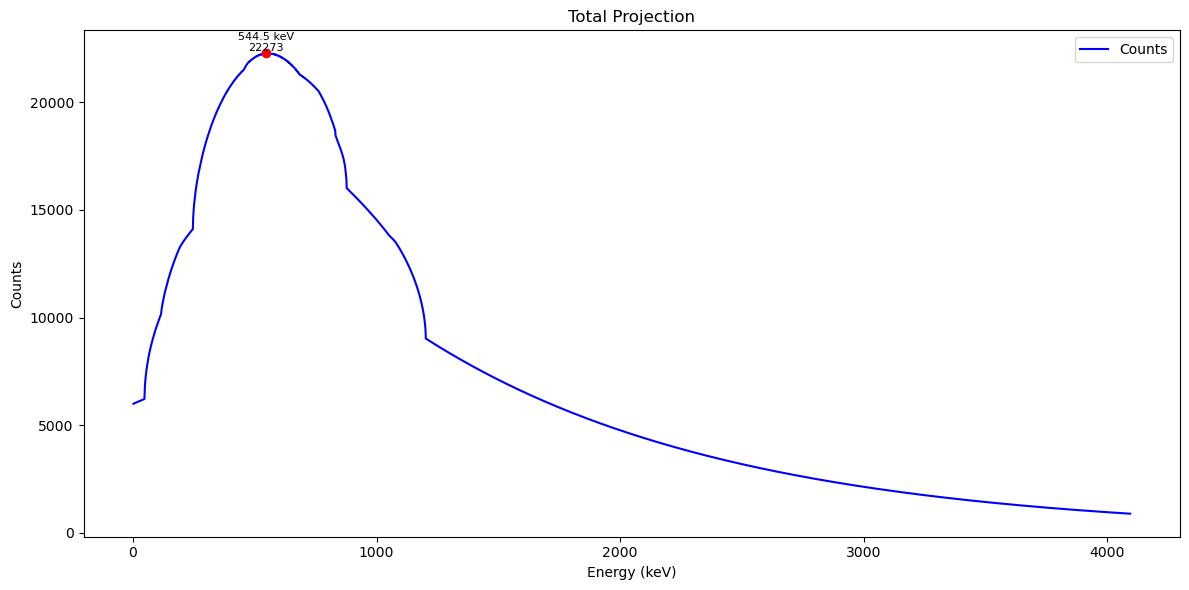

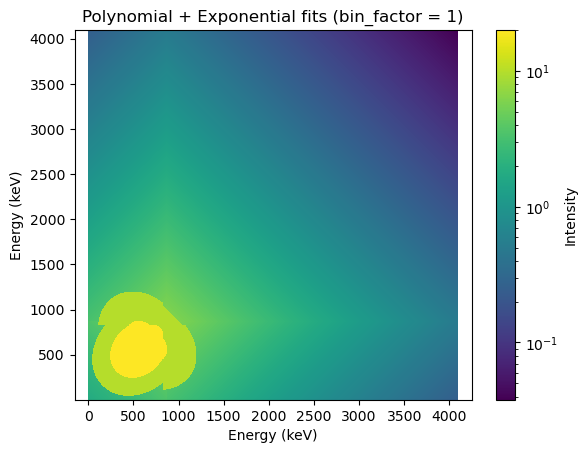

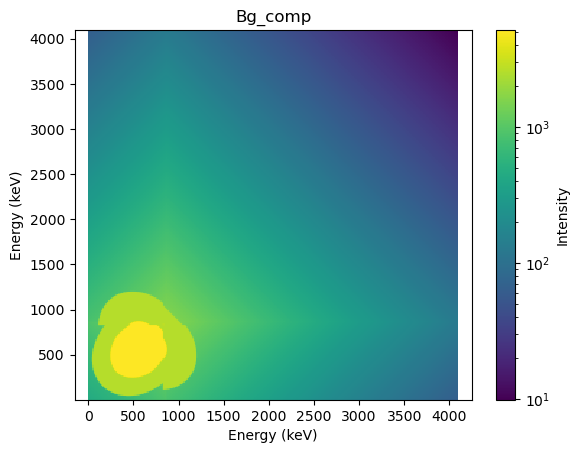

In [29]:
bg_file_path = 'Co56bg.npy'
bg = np.load(bg_file_path)
bgclipped = np.clip(bg, a_min=0, a_max=None)



TotalProjection(bg)
plt.figure()

np.shape(bg)


N = 4096
bin_factor = 1
energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))


plt.imshow(bg, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
                   extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
plt.colorbar(label="Intensity")
plt.title(f"Polynomial + Exponential fits (bin_factor = {bin_factor})")
plt.xlabel("Energy (keV)")
plt.ylabel("Energy (keV)")
plt.axis('equal')
plt.show()

bin_factor = 16

bg_comp = compress_matrix(bg, bin_factor)


plt.figure()
plt.imshow(bg_comp, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
                   extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
plt.colorbar(label="Intensity")
plt.title(f"Bg_comp")
plt.xlabel("Energy (keV)")
plt.ylabel("Energy (keV)")
plt.axis('equal')
plt.show()


<Axes: title={'center': 'Total Projection'}, xlabel='Energy (keV)', ylabel='Counts'>

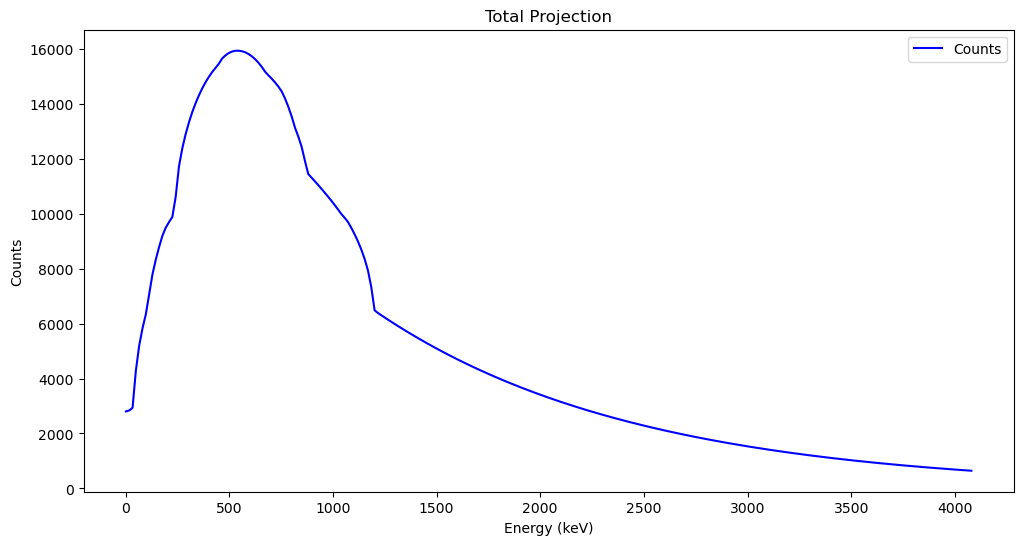

In [11]:
bgc = bg_comp.copy()
bgc *= 0.045

TotalProjection(bgc, 0, bin_factor = 16)

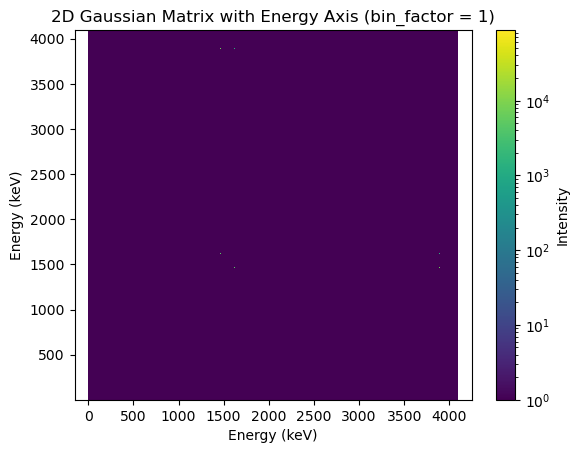

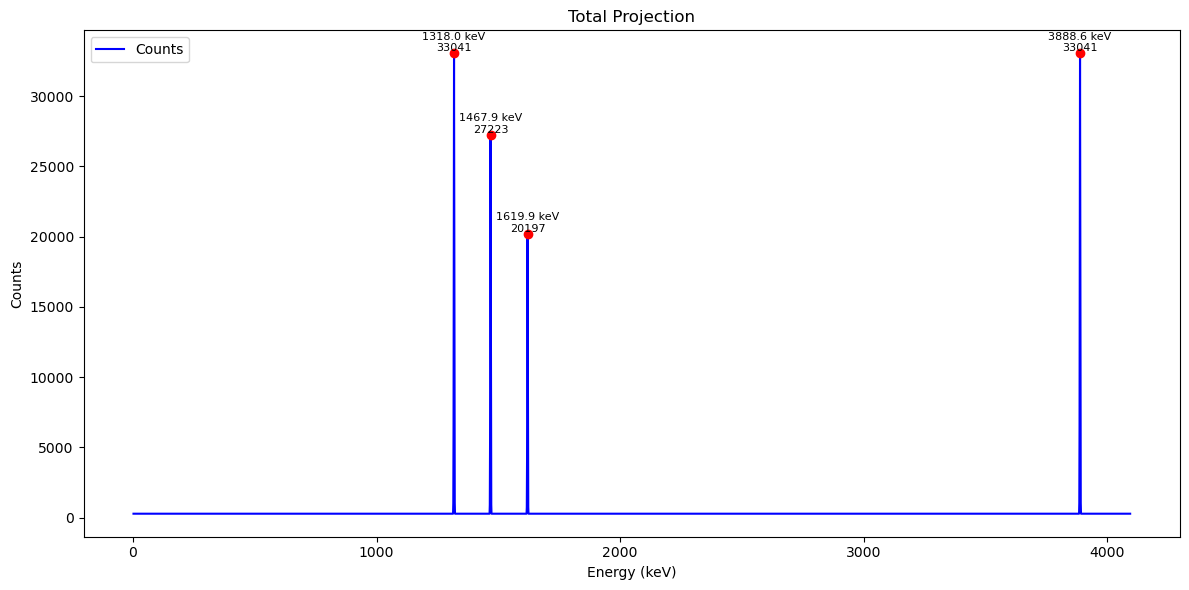

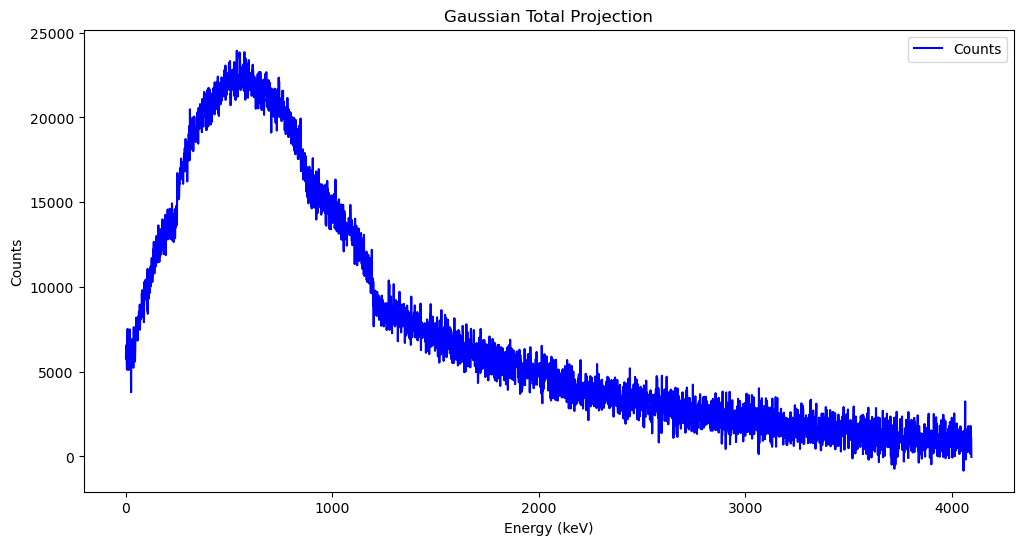

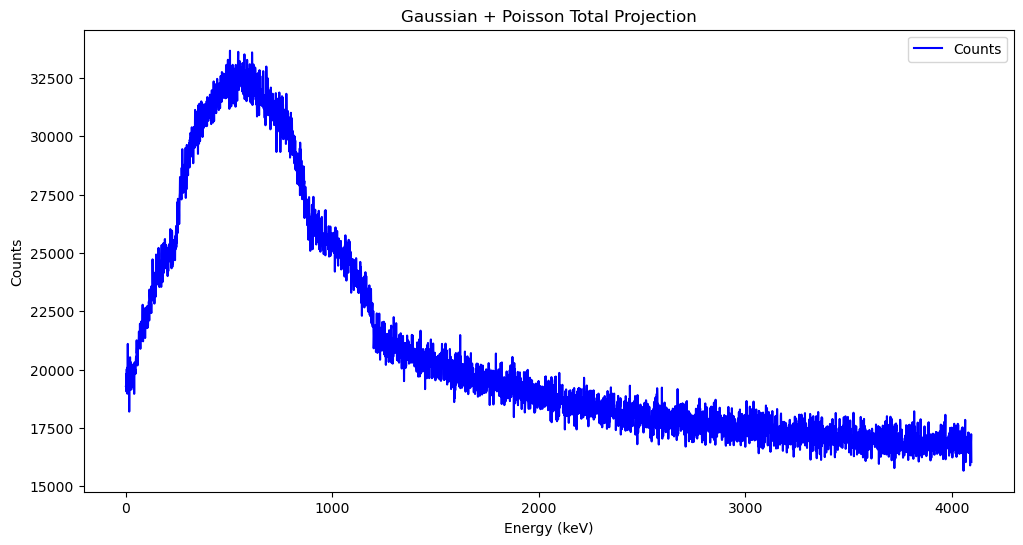

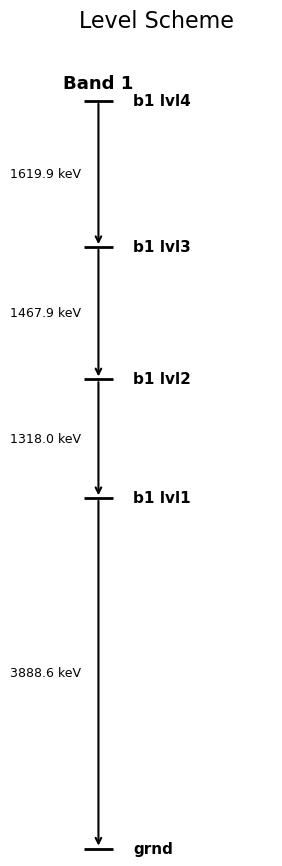

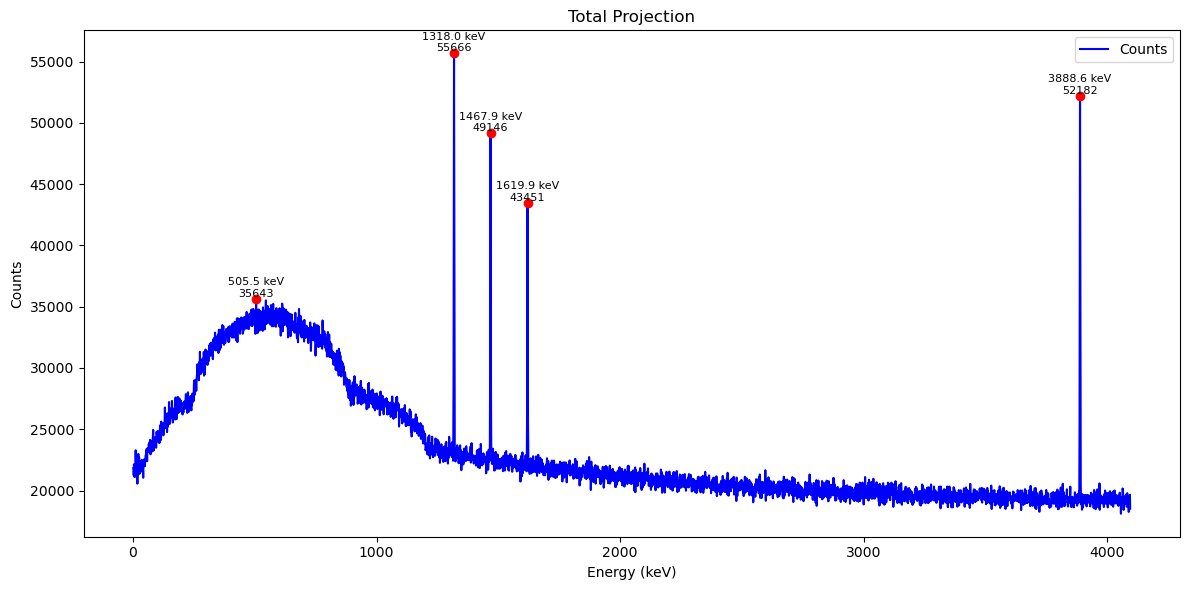

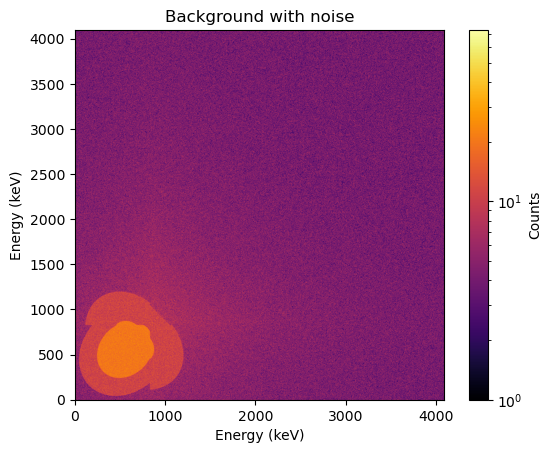

<Figure size 640x480 with 0 Axes>

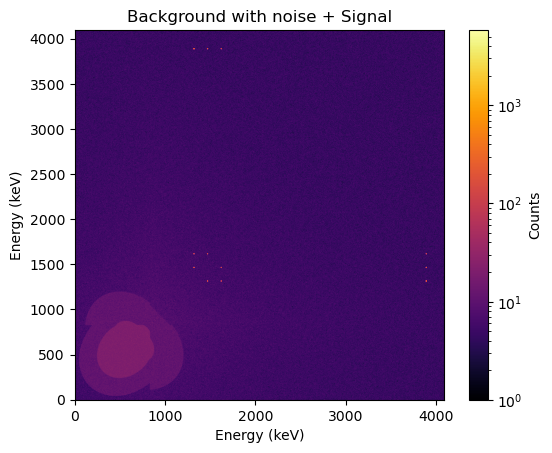

()

<Figure size 640x480 with 0 Axes>

In [31]:
seed = 10
dim = 4096
bin_factor = 4096//dim
max_rungs = 3

def index_to_energy(index, bin_factor=bin_factor):
    return (1.785 + (0.99943 * (index * bin_factor)))
def add_poisson_noise(background):
    noisy_background = np.random.poisson(lam=np.clip(background, 0, None))
    upper = np.triu(noisy_background)
    matrix = upper + upper.T - np.diag(np.diag(noisy_background))
    return matrix

def add_gaussian_noise(matrix, mean=0, std=1):
    noise = np.random.normal(loc=mean, scale=std, size=matrix.shape)
    mask = matrix != 0  # noise isn't applied to 0s
    noisy_matrix = matrix.copy()
    noisy_matrix[mask] += noise[mask]
    return noisy_matrix





N = 4096//bin_factor
#energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))

matrix, level_scheme = simulate_2D_matrix(seed, max_rungs, bin_factor=bin_factor, num_ladders=1)

matrix = matrix/15

TotalProjection(matrix, bin_factor=bin_factor)

bgcg = add_gaussian_noise(bg, std=10)
bgcp = (add_poisson_noise(bgcg))



TotalProjection(bgcg, 0, title = 'Gaussian Total Projection', bin_factor=bin_factor)
TotalProjection(bgcp, 0, title = 'Gaussian + Poisson Total Projection', bin_factor=bin_factor)


matrix_bg = np.clip(add_poisson_noise(matrix + bgcp), a_min=1, a_max=None)


plot_level_bands(level_scheme)

TotalProjection(matrix_bg, bin_factor=bin_factor, prominence=1e4)

plt.figure()
TwoDPlot(bgcp, 'Background with noise')
plt.figure()
TwoDPlot(matrix_bg, 'Background with noise + Signal')


In [72]:
np.array_equal(matrix_bg, matrix_bg.T)

True

512


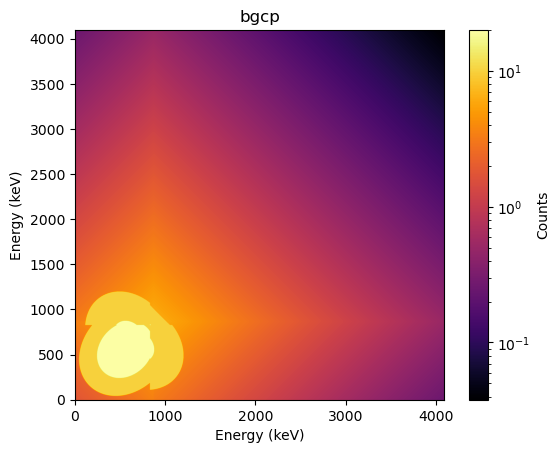

TypeError: TwoDPlot() got an unexpected keyword argument 'bin_factor'

<Figure size 640x480 with 0 Axes>

In [142]:
sims = {}
num_sims = 100
max_rungs = 3
dim_pref = 4096
bin_factor = 4096//dim_pref
dim_actual = 4096//bin_factor
num_ladders = random.randint(3,5)
start_time = time.time()
print(dim_actual)


bgscaled = bg * 100
bgcompressed = compress_matrix(bgscaled, bin_factor=bin_factor)

TwoDPlot(bg, title='bgcp')

TwoDPlot(bgcompressed, title='bgcompressed', bin_factor=bin_factor)


for i in range(num_sims):
    start_time_i = time.time()

    matrix, level_scheme = simulate_2D_matrix(seed, max_rungs, bin_factor=bin_factor, num_ladders=num_ladders, plot=False)

    matrix = matrix/15

    bgcg = add_gaussian_noise(bgcompressed, std=10)
    bgcp = (add_poisson_noise(bgcg))

    matrix_bg = np.clip(add_poisson_noise(matrix + bgcp), a_min=1, a_max=None)

    sims[f'matrix_{i}'] = matrix_bg
    sims[f'level_scheme_{i}'] = level_scheme
    end_time = time.time()
    elapsed_time = end_time - start_time_i
    print(f"Elapsed Time for trial {i+1}: {elapsed_time} seconds")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time Total: {elapsed_time} seconds")

np.savez(f'simulation_results{max_rungs}r{dim_actual}x.npz', **sims)


In [120]:
# how to unpack data

data = np.load('simulation_results3r512x.npz', allow_pickle=True)

matrix_0 = data['matrix_0']

matrix_keys = [k for k in data.files if k.startswith('matrix_')]
matrix_list = [data[k] for k in matrix_keys]

level_scheme_keys = [k for k in data.files if k.startswith('level_scheme_')]
level_scheme_list = [data[k] for k in level_scheme_keys]

x = matrix_list[14]
y = level_scheme_list[14]

In [118]:
print(bin_factor)

8.0


512


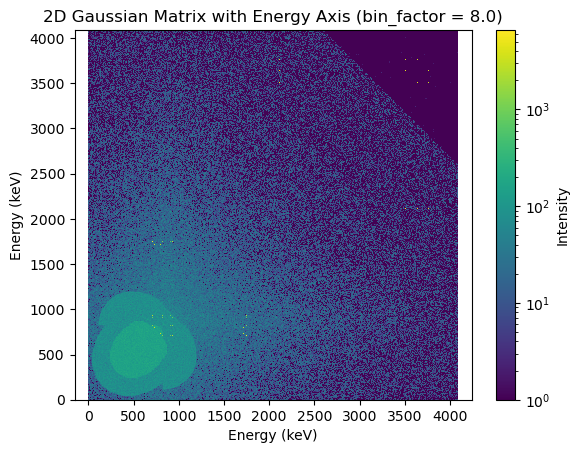

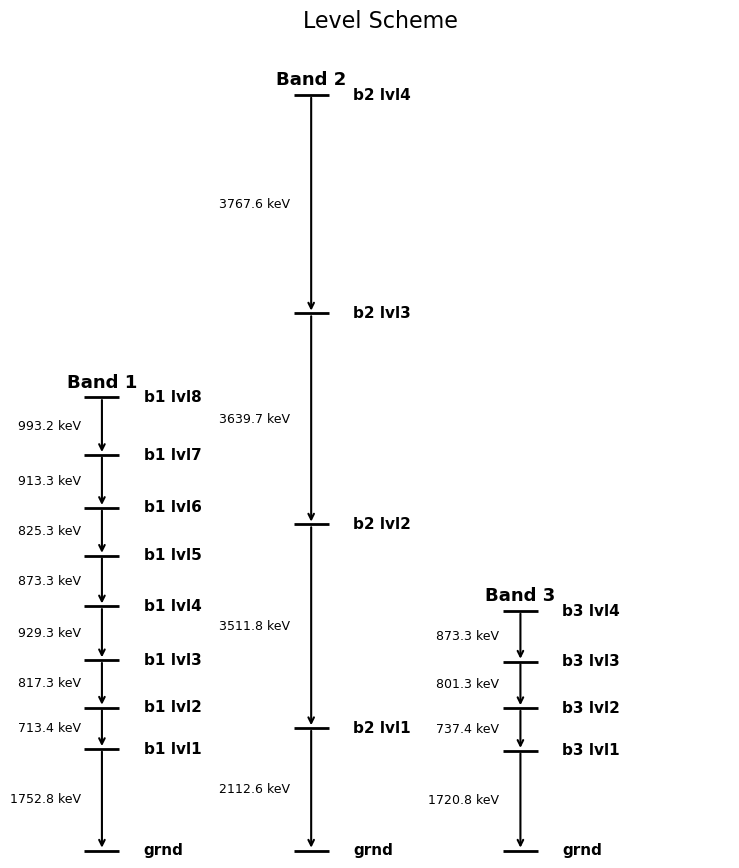

In [122]:
N = x.shape[0]
print(N)
bin_factor = 4096/N
energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))

extent = [0, energy_axis[-1], 0, energy_axis[-1]]

plt.imshow(x, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
           extent=extent)
plt.colorbar(label="Intensity")
plt.title(f"2D Gaussian Matrix with Energy Axis (bin_factor = {bin_factor})")
plt.xlabel("Energy (keV)")
plt.ylabel("Energy (keV)")
plt.axis('equal')
plt.show()

plot_level_bands(y)


array([ 545.5, 1696.8, 1984.7, 2064.6, 2216.5, 2248.5, 2264.5, 2344.4,
       2384.4, 2456.4, 2680.3, 2816.2])

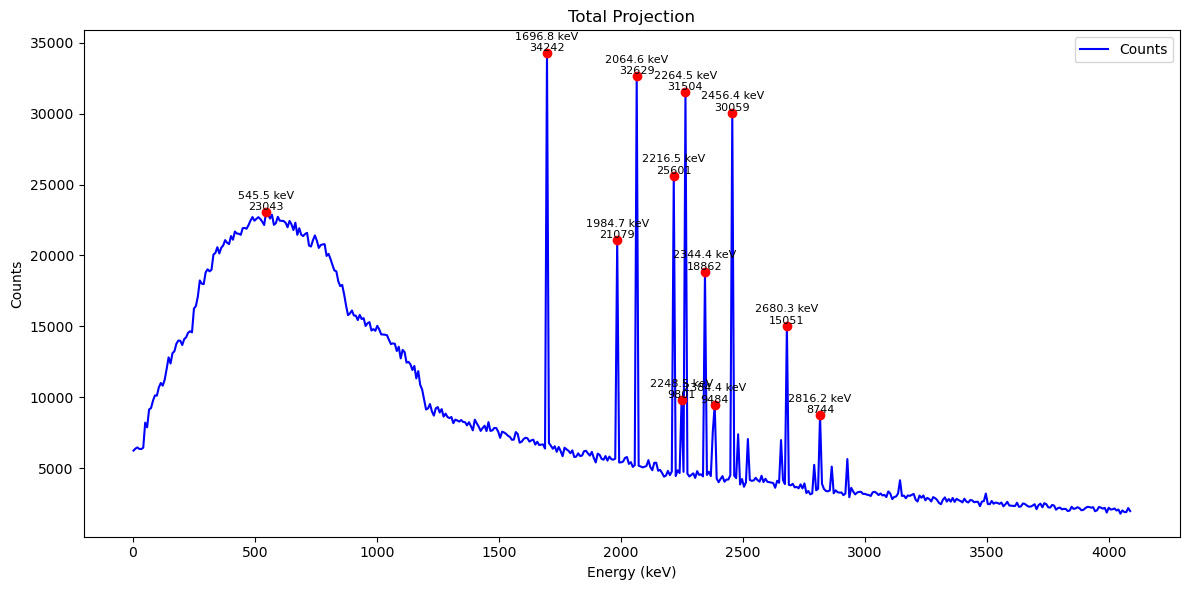

In [115]:
TotalProjection(x, 1, bin_factor=bin_factor, prominence=4e3)

array([  40.8,   46.8,   57.8,   66.7,   74.7,   84.7,   89.7,  110.7,
        114.7,  124.7,  145.7,  154.7,  171.7,  181.7,  191.7,  196.7,
        202.7,  211.7,  216.7,  229.7,  240.6,  253.6,  260.6,  265.6,
        271.6,  278.6,  287.6,  298.6,  302.6,  309.6,  321.6,  329.6,
        335.6,  344.6,  357.6,  362.6,  364.6,  369.6,  375.6,  385.6,
        389.6,  396.6,  400.6,  412.6,  417.5,  419.5,  431.5,  443.5,
        453.5,  462.5,  476.5,  485.5,  491.5,  497.5,  511.5,  526.5,
        538.5,  542.5,  548.5,  555.5,  564.5,  578.5,  587.5,  595.4,
        602.4,  619.4,  633.4,  640.4,  646.4,  653.4,  666.4,  678.4,
        684.4,  693.4,  702.4,  708.4,  714.4,  723.4,  738.4,  747.4,
        754.4,  765.3,  777.3,  786.3,  808.3,  823.3,  837.3,  846.3,
        859.3,  875.3,  894.3,  900.3,  911.3,  925.3,  931.3,  942.2,
        953.2,  968.2,  977.2,  984.2,  990.2,  996.2, 1009.2, 1023.2,
       1042.2, 1058.2, 1072.2, 1086.2, 1097.2, 1118.1, 1130.1, 1145.1,
      

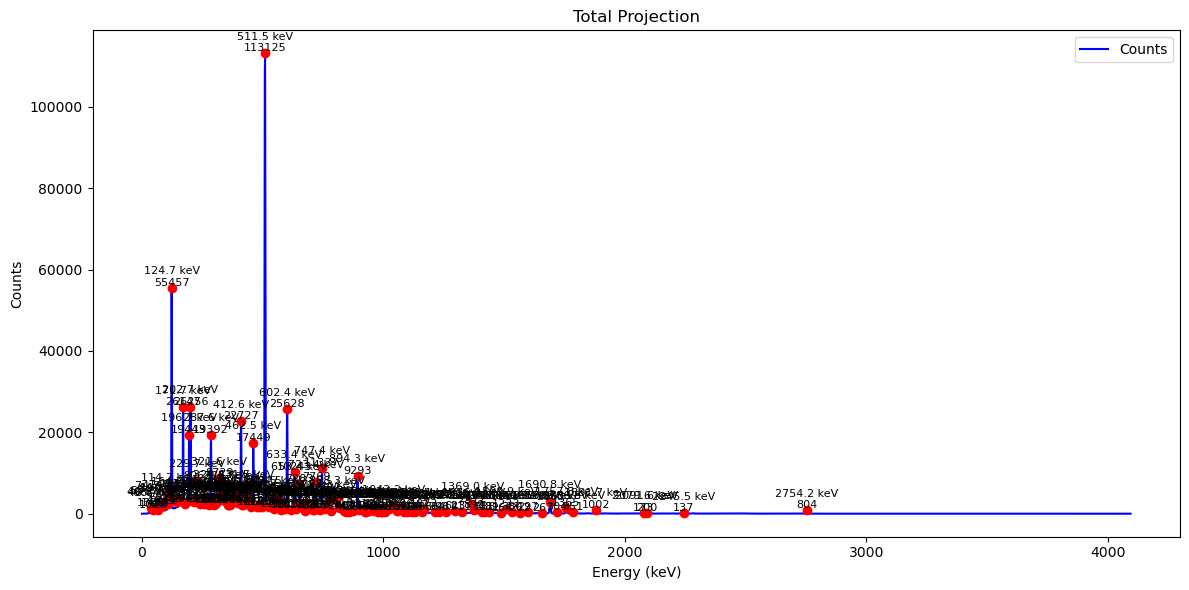

In [51]:
TotalProjection(background, bin_factor=1)


array([3.8000e+00, 6.8000e+00, 9.8000e+00, ..., 4.0835e+03, 4.0875e+03,
       4.0905e+03])

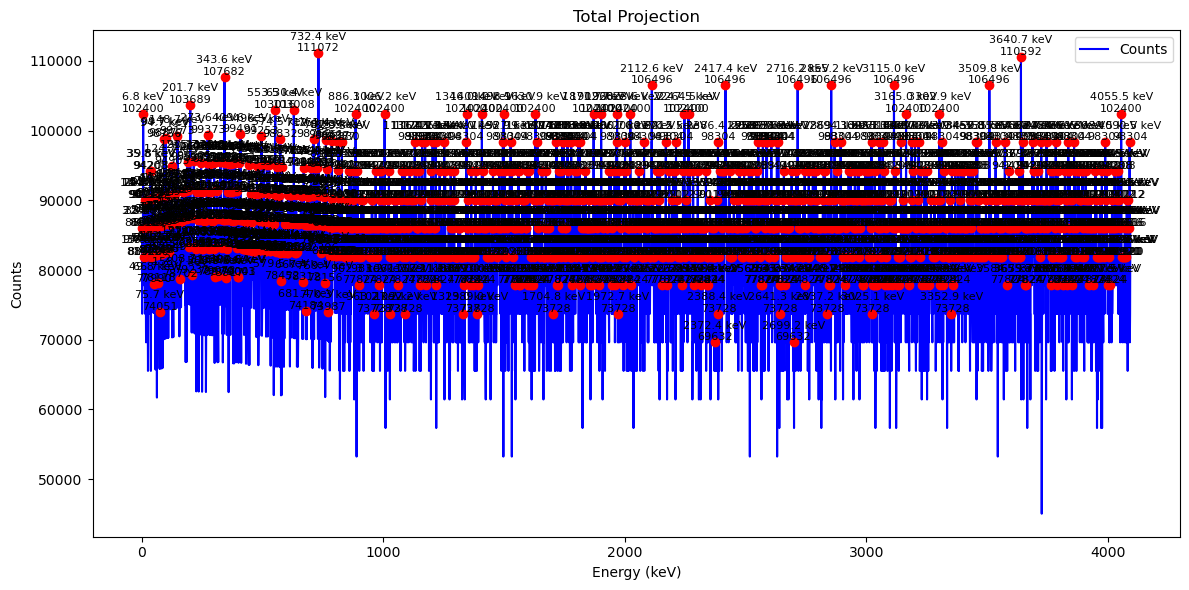

In [97]:

background_filtered2 += 0

TotalProjection(background_filtered2, bin_factor=1)


In [41]:
from scipy.ndimage import correlate1d
correlate1d([2, 8, 0, 4, 1, 9, 9, 0], weights=[1, 3])


array([ 8, 26,  8, 12,  7, 28, 36,  9])

In [43]:
from scipy.ndimage import convolve1d

input_array = [2, 8, 0, 4, 1]
kernel = [1, 3]

result = convolve1d(input_array, kernel)
print(result)

[14 24  4 13  4]


In [67]:
np.uint32(10*(np.random.normal(1, .2, 4096)))

array([ 8, 10, 12, ..., 10, 12,  9], dtype=uint32)